# Recommendation Engines Homework

Working through different types of recommendation systems for this assignment.

In [1]:
# importing what I need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings("ignore")

# setting up plots
plt.style.use("seaborn-v0_8")

## Part 1: Setting up the data

In [2]:
# creating fake data since we dont have real data
np.random.seed(42)

# making a matrix with 100 users and 50 items
n_users = 100
n_items = 50
# ratings from 0-5, with lots of 0s (sparse data)
ratings = np.random.choice([0, 1, 2, 3, 4, 5], size=(n_users, n_items), p=[0.6, 0.1, 0.1, 0.1, 0.05, 0.05])

users = [f"User_{i}" for i in range(n_users)]
items = [f"Item_{i}" for i in range(n_items)]

df = pd.DataFrame(ratings, index=users, columns=items)
print("Matrix shape:", df.shape)
print(df.head())

Matrix shape: (100, 50)
        Item_0  Item_1  Item_2  Item_3  Item_4  Item_5  Item_6  Item_7  \
User_0       0       5       2       0       0       0       0       3   
User_1       5       2       4       3       0       4       0       0   
User_2       0       1       0       0       4       0       0       2   
User_3       4       0       0       0       5       0       1       2   
User_4       1       0       0       3       1       0       0       1   

        Item_8  Item_9  ...  Item_40  Item_41  Item_42  Item_43  Item_44  \
User_0       1       2  ...        0        0        0        4        0   
User_1       0       0  ...        0        2        2        0        2   
User_2       0       0  ...        5        0        0        0        0   
User_3       0       2  ...        0        3        4        1        0   
User_4       0       0  ...        4        5        4        0        0   

        Item_45  Item_46  Item_47  Item_48  Item_49  
User_0        1     

Total ratings: 5205
Average rating: 1.04
How sparse: 60.0%


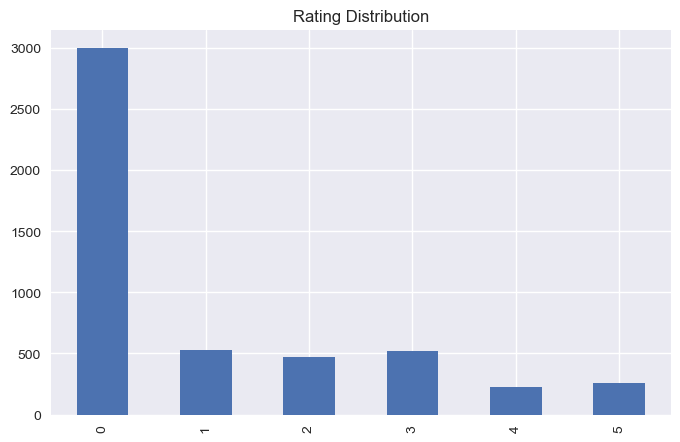

In [3]:
# checking the data
print(f"Total ratings: {df.values.sum()}")
print(f"Average rating: {df.values.mean():.2f}")
print(f"How sparse: {(df == 0).sum().sum() / (n_users * n_items) * 100:.1f}%")

# plot distribution
rating_dist = pd.Series(ratings.flatten()).value_counts().sort_index()
plt.figure(figsize=(8, 5))
rating_dist.plot(kind="bar")
plt.title("Rating Distribution")
plt.show()

## Part 2: User-based collaborative filtering

Trying to find similar users and recommend based on what they liked.

In [4]:
def user_cf(user_id, num_recs=5):
    # get this users ratings
    user_ratings = df.loc[user_id]
    
    # find similar users
    similarities = cosine_similarity([user_ratings], df)[0]
    similar_users = pd.Series(similarities, index=users).sort_values(ascending=False)[1:6]  # top 5
    
    # find items this user hasnt rated
    unrated = user_ratings[user_ratings == 0].index
    
    # predict ratings
    predictions = {}
    for item in unrated:
        item_ratings = df.loc[similar_users.index, item]
        rated_by_similar = item_ratings[item_ratings > 0]
        if len(rated_by_similar) > 0:
            weights = similar_users.loc[rated_by_similar.index]
            pred = np.average(rated_by_similar, weights=weights)
            predictions[item] = pred
    
    # get top recommendations
    recs = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
    return recs[:num_recs]

# test it
test_user = "User_0"
recs = user_cf(test_user)
print(f"Recommendations for {test_user}:")
for item, score in recs:
    print(f"{item}: {score:.2f}")

Recommendations for User_0:
Item_36: 4.50
Item_48: 4.12
Item_17: 3.32
Item_39: 3.15
Item_21: 3.05


## Part 3: Item-based collaborative filtering

Now trying item similarities instead of user similarities.

In [5]:
def item_cf(user_id, num_recs=5):
    user_ratings = df.loc[user_id]
    
    # calculate item similarities
    item_sim = cosine_similarity(df.T)
    item_sim_df = pd.DataFrame(item_sim, index=items, columns=items)
    
    unrated = user_ratings[user_ratings == 0].index
    
    predictions = {}
    for item in unrated:
        rated_items = user_ratings[user_ratings > 0].index
        if len(rated_items) > 0:
            sims = item_sim_df.loc[item, rated_items]
            ratings = user_ratings[rated_items]
            # only use positive similarities
            pos_sims = sims > 0
            if pos_sims.sum() > 0:
                pred = np.average(ratings[pos_sims], weights=sims[pos_sims])
                predictions[item] = pred
    
    recs = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
    return recs[:num_recs]

# test item-based
item_recs = item_cf(test_user)
print(f"Item-based recommendations for {test_user}:")
for item, score in item_recs:
    print(f"{item}: {score:.2f}")

Item-based recommendations for User_0:
Item_22: 2.75
Item_37: 2.75
Item_31: 2.74
Item_27: 2.73
Item_24: 2.70


## Part 4: Matrix Factorization with NMF

Trying matrix factorization to find latent factors.

In [6]:
# prep data for NMF - replace 0s with item averages
df_nmf = df.copy()
df_nmf = df_nmf.replace(0, np.nan)
item_means = df_nmf.mean()
df_nmf = df_nmf.fillna(item_means)

# run NMF
nmf = NMF(n_components=10, random_state=42)
W = nmf.fit_transform(df_nmf)  # user factors
H = nmf.components_  # item factors

# reconstruct
reconstructed = np.dot(W, H)

print(f"Original shape: {df.shape}")
print(f"User factors: {W.shape}")
print(f"Item factors: {H.shape}")
print(f"Reconstruction error: {nmf.reconstruction_err_:.3f}")

Original shape: (100, 50)
User factors: (100, 10)
Item factors: (10, 50)
Reconstruction error: 44.603


In [7]:
def nmf_recs(user_id, num_recs=5):
    user_idx = users.index(user_id)
    user_preds = reconstructed[user_idx]
    
    # only recommend unrated items
    original = df.loc[user_id]
    unrated_mask = original == 0
    
    unrated_preds = user_preds[unrated_mask]
    unrated_items = original[unrated_mask].index
    
    recs = list(zip(unrated_items, unrated_preds))
    recs.sort(key=lambda x: x[1], reverse=True)
    return recs[:num_recs]

# test NMF
nmf_recommendations = nmf_recs(test_user)
print(f"NMF recommendations for {test_user}:")
for item, score in nmf_recommendations:
    print(f"{item}: {score:.2f}")

NMF recommendations for User_0:
Item_36: 3.51
Item_5: 3.47
Item_46: 3.38
Item_17: 3.27
Item_41: 3.19


## Part 5: Content-based filtering

Making up some item features to try content-based recommendations.

In [8]:
# creating fake item features
np.random.seed(42)
categories = ["Electronics", "Books", "Clothing", "Home", "Sports"]

item_features = {}
for item in items:
    item_features[item] = {
        "category": np.random.choice(categories),
        "price": np.random.choice(["Low", "Medium", "High"]),
        "rating": np.random.uniform(3.0, 5.0)
    }

features_df = pd.DataFrame.from_dict(item_features, orient="index")
print("Item features:")
print(features_df.head())

Item features:
        category   price    rating
Item_0      Home     Low  3.366870
Item_1    Sports     Low  3.312037
Item_2  Clothing    High  3.116167
Item_3    Sports    High  3.041169
Item_4     Books  Medium  3.424678


In [9]:
def content_recs(user_id, num_recs=5):
    user_ratings = df.loc[user_id]
    rated_items = user_ratings[user_ratings > 0]
    
    if len(rated_items) == 0:
        # if no ratings, just recommend popular items
        popular = features_df.sort_values("rating", ascending=False).index
        return [(item, features_df.loc[item, "rating"]) for item in popular[:num_recs]]
    
    # build user profile from rated items
    rated_features = features_df.loc[rated_items.index]
    fav_category = rated_features["category"].value_counts().index[0]
    fav_price = rated_features["price"].value_counts().index[0]
    
    # score unrated items
    unrated = user_ratings[user_ratings == 0].index
    scores = {}
    
    for item in unrated:
        score = 0
        item_feat = features_df.loc[item]
        
        if item_feat["category"] == fav_category:
            score += 2
        if item_feat["price"] == fav_price:
            score += 1
        score += item_feat["rating"]  # add base rating
        
        scores[item] = score
    
    recs = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return recs[:num_recs]

# test content-based
content_recommendations = content_recs(test_user)
print(f"Content-based recommendations for {test_user}:")
for item, score in content_recommendations:
    print(f"{item}: {score:.1f}")

Content-based recommendations for User_0:
Item_40: 7.2
Item_32: 7.2
Item_23: 6.9
Item_14: 6.4
Item_3: 6.0


## Comparing the methods

Quick comparison of coverage for different approaches.

In [10]:
# test on a few users to see coverage
test_users = users[:10]
methods = [("User CF", user_cf), ("Item CF", item_cf), ("NMF", nmf_recs), ("Content", content_recs)]

results = {}
for name, func in methods:
    all_recs = []
    for user in test_users:
        try:
            recs = func(user)
            all_recs.extend([item for item, score in recs])
        except:
            pass
    
    unique_items = len(set(all_recs))
    coverage = unique_items / len(items) * 100
    results[name] = coverage
    print(f"{name}: {unique_items} unique items, {coverage:.1f}% coverage")

User CF: 31 unique items, 62.0% coverage
Item CF: 35 unique items, 70.0% coverage
NMF: 36 unique items, 72.0% coverage
Content: 33 unique items, 66.0% coverage


## Summary

Tried different recommendation approaches:
- User-based collaborative filtering
- Item-based collaborative filtering  
- Matrix factorization with NMF
- Content-based filtering

Each has different strengths. Collaborative filtering works well with enough data, content-based helps with cold start, and matrix factorization can find latent patterns.